# Udacity Self-Driving Car Engineer Nanodegree Program¶


##                                               Vehicle Detection Project

## Extract data

Number of cars in data base 8968
Number of noncars in data base 8968
Number of cars in data base after insersion 8968


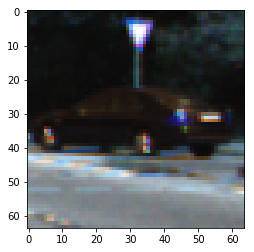

In [182]:
'''from skimage.feature import hog
from sklearn.svm import LinearSVC
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import pickle
import cv2
import glob
'''

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
from shutil import copyfile
from skimage.feature import hog
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
%matplotlib inline
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split


car_imgs=glob.glob('data/vehicles/*/*.png')
noncar_imgs=glob.glob('data/non-vehicles/*/*.png')
print("Number of cars in data base", len(car_imgs))
print("Number of noncars in data base", len(noncar_imgs))
# since the size of non car vehicles are not the same as car vehicles, we add random car
if (len(noncar_imgs)!=len(car_imgs)):
    for i in range(len(noncar_imgs)-len(car_imgs)):
        car_ind = np.random.randint(0, len(car_imgs))
        copyfile(car_imgs[car_ind], 'data/vehicles/added_by_mehdi/added'+str(i)+'.png')

    
car_imgs=glob.glob('data/vehicles/*/*.png')
noncar_imgs=glob.glob('data/non-vehicles/*/*.png')
print("Number of cars in data base after insersion", len(car_imgs))
plt.imshow(cv2.imread(car_imgs[np.random.randint(0, len(car_imgs))]))


## Histogram of Oriented Gradients (HOG) and spacial and color histogram

In [391]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
   # imp=np.int32(img)    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features  
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)): 
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    # we need just the histgogram not the bins edge therefore we add [0]
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

print ("compiled!")

compiled!


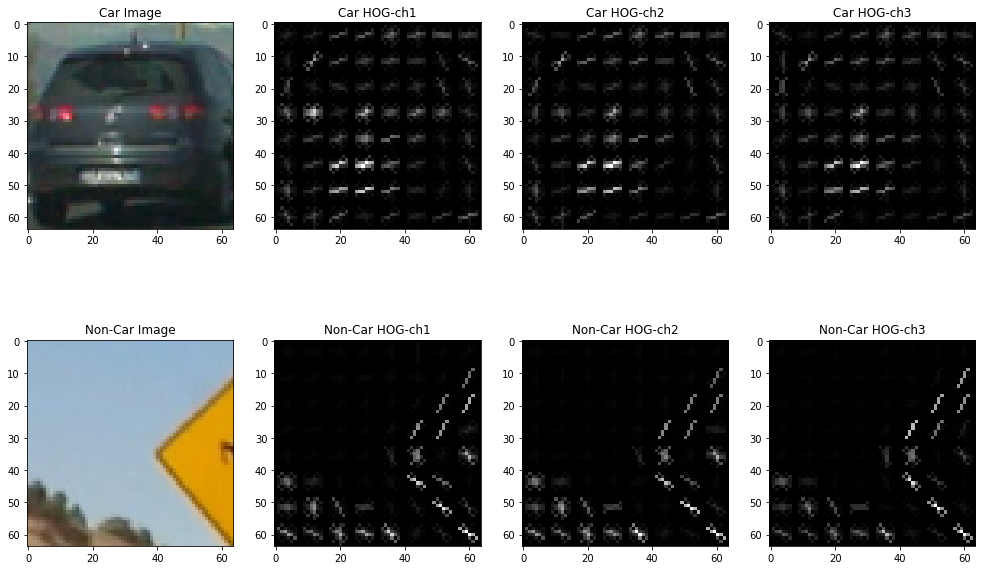

In [208]:

car_sample=mpimg.imread(car_imgs[1234]) 
noncar_sample=mpimg.imread(noncar_imgs[1234])
features,car_sample_hot_on_ch1=get_hog_features(car_sample[:,:,0], orient=9, pix_per_cell=8, cell_per_block=4,vis=True, feature_vec=True)
features,car_sample_hot_on_ch2=get_hog_features(car_sample[:,:,1], orient=9, pix_per_cell=8, cell_per_block=4,vis=True, feature_vec=True)
features,car_sample_hot_on_ch3=get_hog_features(car_sample[:,:,2], orient=9, pix_per_cell=8, cell_per_block=4,vis=True, feature_vec=True)
features,noncar_sample_hot_on_ch1=get_hog_features(noncar_sample[:,:,0], orient=9, pix_per_cell=8, cell_per_block=4,vis=True, feature_vec=True)
features,noncar_sample_hot_on_ch2=get_hog_features(noncar_sample[:,:,1], orient=9, pix_per_cell=8, cell_per_block=4,vis=True, feature_vec=True)
features,noncar_sample_hot_on_ch3=get_hog_features(noncar_sample[:,:,2], orient=9, pix_per_cell=8, cell_per_block=4,vis=True, feature_vec=True)

f, ((ax1, ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, figsize=(17,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_sample)
ax1.set_title('Car Image', fontsize=12)
ax2.imshow(car_sample_hot_on_ch1, cmap='gray')
ax2.set_title('Car HOG-ch1', fontsize=12)
ax3.imshow(car_sample_hot_on_ch2, cmap='gray')
ax3.set_title('Car HOG-ch2', fontsize=12)
ax4.imshow(car_sample_hot_on_ch3, cmap='gray')
ax4.set_title('Car HOG-ch3', fontsize=12)
ax5.imshow(noncar_sample)
ax5.set_title('Non-Car Image', fontsize=12)
ax6.imshow(noncar_sample_hot_on_ch1, cmap='gray')
ax6.set_title('Non-Car HOG-ch1', fontsize=12)
ax7.imshow(noncar_sample_hot_on_ch2, cmap='gray')
ax7.set_title('Non-Car HOG-ch2', fontsize=12)
ax8.imshow(noncar_sample_hot_on_ch3, cmap='gray')
ax8.set_title('Non-Car HOG-ch3', fontsize=12)

## Extract Features

In [393]:

def get_feature(feat_img,orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spacial_size=(32, 32), nbins=32, bins_range=(0, 256),
                     HOG_feature=True,Spacial_feature=True,Histogram_feature=True):
    features = []
    if HOG_feature == True:
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feat_img.shape[2]):
                feat=get_hog_features(feat_img[:,:,channel], orient,
                                    pix_per_cell, cell_per_block,vis=False, feature_vec=True)
                hog_features.append(feat)
                
               # print("each hog feature",hog_features)
               # print("each hog feature",len(hog_features))
            hog_features = np.ravel(hog_features)
           # print(len(hog_features))
        if hog_channel == 0 or hog_channel == 1 or hog_channel == 2:
            hog_features.append(get_hog_features(feat_img[:,:,hog_channel], orient,
                                    pix_per_cell, cell_per_block,vis=False, feature_vec=True))
        # Append the new feature vector to the features list
        #print("hog")
        #print(hog_features)
        #features.append(hog_features)
    if Spacial_feature == True:
        spacial_feature = bin_spatial(feat_img, size=spacial_size)
        #features.append(spacial_feature)

       # print("spacial")
        print(len(spacial_feature))
       # print(spacial_feature)
    print(len(hog_features))
    if Histogram_feature == True:
        histogram_feature = color_hist(feat_img, nbins=nbins, bins_range=bins_range)
        print(len(histogram_feature))
    #features.append(histogram_feature)
    if len(hog_features) > 0 and len(spacial_feature) > 0  and len(histogram_feature) > 0 :  
        features.append(np.concatenate((hog_features,spacial_feature,histogram_feature)))
    elif len(hog_features) <= 0 and len(spacial_feature) > 0  and len(histogram_feature) > 0 :  
        features.append(np.concatenate((spacial_feature,histogram_feature)))
    elif len(hog_features) > 0 and len(spacial_feature) <= 0  and len(histogram_feature) > 0 :  
        features.append(np.concatenate((hog_features,histogram_feature)))
    elif len(hog_features) > 0 and len(spacial_feature) > 0  and len(histogram_feature) <= 0 :  
        features.append(np.concatenate((hog_features,spacial_feature)))
    elif len(hog_features) <= 0 and len(spacial_feature) <= 0  and len(histogram_feature) > 0 :  
        features.append(histogram_feature)
    elif len(hog_features) <= 0 and len(spacial_feature) > 0  and len(histogram_feature) <= 0 :  
        features.append(spacial_feature)
    elif len(hog_features) > 0 and len(spacial_feature) <= 0  and len(histogram_feature) <= 0 :  
        features.append(hog_features)
      
      
        #print("hist")
        #print(len(histogram_feature))
        #print(histogram_feature)
    #print(features)
    return  features   
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spacial_size=(32, 32), nbins=32, bins_range=(0, 256),
                     HOG_feature=True,Spacial_feature=True,Histogram_feature=True):
    # Create a list to append feature vectors to
    final_features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        # since the photo is read by mpimg.imread the output is in RGB, while if it is read by
        # cv2.imread(), the result is in BGR format
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)  
        #feature_image *= (255.0/feature_image.max()) 
        original_img_feature = get_feature(feature_image,orient, pix_per_cell, cell_per_block, hog_channel,
                     spacial_size, nbins, bins_range, HOG_feature,Spacial_feature,Histogram_feature)
        #print(final_features)
        #final_features.append(np.concatenate(original_img_feature))
        #final_features.append(original_img_feature)
        fliped_image = cv2.flip(feature_image,1)
        fliped_img_feature = get_feature(fliped_image,orient, pix_per_cell, cell_per_block, hog_channel,
                     spacial_size, nbins, bins_range, HOG_feature,Spacial_feature,Histogram_feature)
        #final_features.append(np.concatenate(fliped_img_feature))
        final_features.append(np.concatenate((original_img_feature, fliped_img_feature)))
        #final_features.append(fliped_img_feature)
   
    return final_features
print("compiled")

compiled


In [223]:
colorspace_range =[ 'HSV','LUV','HLS','YUV']
orient_range = [8,11,14,16]
pix_per_cell_range = [8,10,14]
cell_per_block_range = [2,4]
hog_channel_range = [0,1,'ALL'] # Can be 0, 1, 2, or "ALL"
spacial_size_input=(16,16)
number_of_bin=32
bins_range_input=(0, 256)
HOG_feature_indicator=True
Spacial_feature_indicator=True
Histogram_feature_indicator=True

fit_result_accuracy=np.zeros([len(colorspace_range),len(orient_range),len(pix_per_cell_range),len(cell_per_block_range),len(hog_channel_range)])
time_to_extract_and_fit=np.zeros([len(colorspace_range),len(orient_range),len(pix_per_cell_range),len(cell_per_block_range),len(hog_channel_range)])


In [411]:
cnt=0
tim=0.
for i1 in range(len(colorspace_range)):
    for i2 in range(len(orient_range)):
        for i3 in range(len(pix_per_cell_range)):
            for i4 in range(len(cell_per_block_range)):
                for i5 in range(len(hog_channel_range)):
                    t=time.time()
                    car_features = extract_features(car_imgs, cspace=colorspace_range[i1], orient=orient_range[i2],
                        pix_per_cell=pix_per_cell_range[i3], cell_per_block=cell_per_block_range[i4],
                        hog_channel=hog_channel_range[i5],spacial_size=spacial_size_input,
                        nbins=number_of_bin, bins_range=bins_range_input,
                        HOG_feature=HOG_feature_indicator,Spacial_feature=Spacial_feature_indicator, Histogram_feature=Histogram_feature_indicator)
                    notcar_features = extract_features(noncar_imgs, cspace=colorspace_range[i1], orient=orient_range[i2],
                       pix_per_cell=pix_per_cell_range[i3], cell_per_block=cell_per_block_range[i4],
                       hog_channel=hog_channel_range[i5],spacial_size=spacial_size_input,
                       nbins=number_of_bin, bins_range=bins_range_input,
                       HOG_feature=HOG_feature_indicator,Spacial_feature=Spacial_feature_indicator, Histogram_feature=Histogram_feature_indicator)
                    # Create an array stack of feature vectors
                    X = np.vstack((car_features, notcar_features)).astype(np.float64)
                    # Define the labels vector
                    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


                    X = X.reshape(len(X),-1)
                    # Fit a per-column scaler only on the training data
                    X_scaler = StandardScaler().fit(X)
                    X_scaled = X_scaler.transform(X)


                    # Split up data into randomized training and test sets
                    rand_state = np.random.randint(0, 100)
                    X_train, X_test, y_train, y_test = train_test_split(
                        X_scaled, y, test_size=0.2, random_state=rand_state)

                    svc = LinearSVC()
                    svc.fit(X_train, y_train)
                    t2 = time.time()
                    fit_result_accuracy[i1][i2][i3][i4][i5]=round(svc.score(X_test, y_test), 4)
                    time_to_extract_and_fit[i1][i2][i3][i4][i5]=round(t2-t, 2)
                    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
                    cnt=cnt+1
                    tim=tim+round(t2-t, 2)
                    print(cnt, tim)
                    print(colorspace_range[i1], orient_range[i2], pix_per_cell_range[i3],cell_per_block_range[i4],hog_channel_range[i5])


3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96
3072
1
96


KeyboardInterrupt: 

In [ ]:

for i1 in range(len(colorspace_range)):
    for i2 in range(len(orient_range)):
        for i3 in range(len(pix_per_cell_range)):
            for i4 in range(len(cell_per_block_range)):
                for i5 in range(len(hog_channel_range)):
                    if fit_result_accuracy[i1][i2][i3][i4][i5]==np.max(fit_result_accuracy):
                        ii1=i1
                        ii2=i2
                        ii3=i3
                        ii4=i4
                        ii5=i5
print( "maximum accuracy is", np.max(fit_result_accuracy), "and goes to :")
print("Color space: ",colorspace_range[ii1])
print("No. of orientation: ",orient_range[ii2])
print("pix per cell: ",pix_per_cell_range[ii3])
print("Cell per block: ",cell_per_block_range[ii4])
print("HOG channel: ",hog_channel_range[ii5])

In [415]:

colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
no_orient = 8
no_pix_per_cell = 10
no_cell_per_block = 4
hog_channel_input = 0 # Can be 0, 1, 2, or "ALL"
spacial_size_input=(16,16)
number_of_bin=32
bins_range_input=(0, 256)
HOG_feature_indicator=True
Spacial_feature_indicator=True
Histogram_feature_indicator=True

t=time.time()
car_features = extract_features(car_imgs, cspace=colorspace, orient=no_orient, pix_per_cell=no_pix_per_cell,
                                cell_per_block=no_cell_per_block, hog_channel=hog_channel_input,spacial_size=spacial_size_input,
                                nbins=number_of_bin, bins_range=bins_range_input, 
                                HOG_feature=HOG_feature_indicator,Spacial_feature=Spacial_feature_indicator, Histogram_feature=Histogram_feature_indicator)
notcar_features = extract_features(noncar_imgs, cspace=colorspace, orient=no_orient, pix_per_cell=no_pix_per_cell,
                                cell_per_block=no_cell_per_block, hog_channel=hog_channel_input,spacial_size=spacial_size_input,
                                nbins=number_of_bin, bins_range=bins_range_input, 
                                HOG_feature=HOG_feature_indicator,Spacial_feature=Spacial_feature_indicator, Histogram_feature=Histogram_feature_indicator)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
print("total car features: ", len(car_features))
print("total non car features: ",len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X = X.reshape(len(X),-1)
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=rand_state)
svc = LinearSVC()
svc.fit(X_train, y_train)
t = time.time()
print(round(t-t2, 2), 'Seconds to train and fit SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
7

96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
96
768
1
9

In [418]:
#print(len(bin_spatial(mpimg.imread('added0.png'), size=spacial_size)))
print(len(bin_spatial(test_imgs, size=(16,16))))

768


In [536]:
   
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    final_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
    #img_features.append(get_feature(feat_img = feature_image, orient = orient, pix_per_cell = pix_per_cell, 
    #                                cell_per_block= cell_per_block, hog_channel= hog_channel,
    #                                spacial_size = spatial_size, nbins=hist_bins, bins_range=(0, 255), 
    #                                HOG_feature=hog_feat,Spacial_feature=spatial_feat,Histogram_feature=hist_feat))

    original_img_feature = get_feature(feat_img = feature_image, orient = orient, pix_per_cell = pix_per_cell, 
                                    cell_per_block= cell_per_block, hog_channel= hog_channel,
                                    spacial_size = spatial_size, nbins=hist_bins, bins_range=(0, 255), 
                                    HOG_feature=hog_feat,Spacial_feature=spatial_feat,Histogram_feature=hist_feat)

    fliped_image = cv2.flip(feature_image,1)
    fliped_img_feature = get_feature(feat_img = fliped_image, orient = orient, pix_per_cell = pix_per_cell, 
                                    cell_per_block= cell_per_block, hog_channel= hog_channel,
                                    spacial_size = spatial_size, nbins=hist_bins, bins_range=(0, 255), 
                                    HOG_feature=hog_feat,Spacial_feature=spatial_feat,Histogram_feature=hist_feat)

    final_features.append(np.concatenate((original_img_feature, fliped_img_feature)))
    return final_features

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
   
        #5) Scale extracted features to be fed to classifier
        #print(features)
        print("********")
        
        #test_feature = np.array(features).reshape(1, -1)
       # test_feature = np.ravel((features, features))
        
        #features = features.reshape(len(features),-1)
       # test_features = X_scaler.transform(features)
       # print(car_features[0])
       # print(features[0][0])
        x1 = np.hstack((features[0][0],features[0][0]))
        x2 = np.hstack((features[0][1],features[0][1]))
        X = np.vstack((x1, x2))
        print(X)
        print(len(X))
        #print(x1)
       # print(len(X))
        test_feature_transformed = X_scaler.transform(X)
 
            
              #6) Predict using your classifier
        prediction = clf.predict(test_feature_transformed)
        print(prediction)
        #7) If positive (prediction == 1) then save the window
        if int(prediction[0]) == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
print ("compiled")    

compiled


768
1
96
768
1
96
********
[[  2.00388416e-03   5.90000000e+01   9.90000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  5.88580805e-04   2.00000000e+01   9.60000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
2
[ 1.  1.]
768
1
96
768
1
96
********
[[  3.58764643e-04   8.00000000e+00   9.60000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  3.78313150e-04   4.40000000e+01   9.50000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
2
[ 1.  1.]
768
1
96
768
1
96
********
[[  4.28710592e-04   4.20000000e+01   9.50000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.78505052e-04   5.10000000e+01   9.70000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
2
[ 1.  1.]
768
1
96
768
1
96
********
[[  3.17664393e-04   4.40000000e+01   9.50000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.04739587e-04   6.20000000e+01   9.60000000e+01 ...,   0.0000000

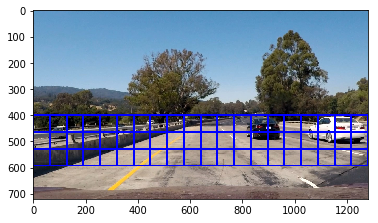

In [538]:
test_imgs_directory=glob.glob('test_images/test1.jpg')
test_imgs=mpimg.imread('test_images/test1.jpg')
#it is a jpg image and I am using mpimg to read it. Since I used mpimg on png image in the pipeline,
# I need to scale the jpg image
#test_imgs = test_imgs.astype(np.float32)/255
draw_image = np.copy(test_imgs)
y_start_stop = [400, 650] # Min and max in y to search in slide_window()
spacial_size_input=(16,16)

windows = slide_window(test_imgs, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))


hot_windows = search_windows(test_imgs, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spacial_size_input, hist_bins=number_of_bin, 
                        orient=no_orient, pix_per_cell=no_pix_per_cell, cell_per_block=no_cell_per_block,
                        hog_channel=hog_channel_input, spatial_feat=Spacial_feature_indicator, 
                        hist_feat=Histogram_feature_indicator, hog_feat=HOG_feature_indicator)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


